In [1]:
# %load_ext memory_profiler

# Capstone V5 model

Forked from: V3
This is a 1 GRU model. The input to the GRU comes from one of the following pre-trained embedding layer:
- glove.840B.300d

The embedding layer is retrained.

The validation F1-score is 0.664 at a threshold of 0.5.

TODO: debug confusion matrix + NN architecture. Might be similar arch issue to v4.

# Constants

In [2]:
MODEL_VERSION = 'capstoneV5'
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300
MAX_WORDS = 50000

## Common english contraction mappings (wikipedia):
https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions

In [3]:
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [4]:
PUNCT = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [5]:
SPECIAL_PUNCT = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}

In [6]:
PUNCT_MAPPING = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [7]:
MISPELL_MAPPING = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

# Helpers

## Embedding helpers

In [8]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import os

def loadEmbeddings(path, dimensions, mode='r', encoding=None, errors=None):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    f = open(path, buffering=((2<<16) + 8), mode=mode, encoding=encoding, errors=errors)
    for line in f:
        if len(line) <= 100:
            continue
        values = line.split()
        word = ''.join(values[:-dimensions])
        coefs = np.asarray(values[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [9]:
def loadEmbeddingsGensim(path, dimensions, binary=True):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    gensim_vecs = KeyedVectors.load_word2vec_format(path, binary=binary)
    for word, vector in zip(gensim_vecs.vocab, gensim_vecs.vectors):
        coefs = np.asarray(vector[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [10]:
def getEmbeddingMatrix(embedding, word_index):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    nb_words = min(MAX_WORDS, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

### Helper to replace contractions in dataset

In [11]:
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([CONTRACTION_MAPPING[t] if t in CONTRACTION_MAPPING else t for t in text.split(" ")])
    return text

### Helper to remap punctuations in dataset

In [12]:
def clean_special_chars(text):
    for p in PUNCT_MAPPING:
        text = text.replace(p, PUNCT_MAPPING[p])
    
    for p in PUNCT:
        text = text.replace(p, ' ' + p + ' ')
    
    for s in SPECIAL_PUNCT:
        text = text.replace(s, SPECIAL_PUNCT[s])
    
    return text

### Helper to correct common mispellings

In [13]:
def correct_spelling(x):
    for word in MISPELL_MAPPING.keys():
        x = x.replace(word, MISPELL_MAPPING[word])
    return x

## Coverage helpers

In [14]:
from collections import Counter

def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = Counter()
    for sentence in sentences:
        for word in sentence:
            vocab[word] += 1
    return vocab

In [15]:
import operator

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

# Import test/train dataset

In [16]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1

# Analyze train and test data

In [17]:
print("Sample insincere questions")
train_df.loc[train_df['target'] == 1].sample(10)

Sample insincere questions


,qid,question_text,target
386406,4bb4b1dc79408b1736e0,Why does the left not see the threat that Islam poses to the west in the not too distant future?,1
946811,b986b84ec2eb2be54d1b,Has the migration of North Indians to South India caused a rise in crime rates in South India?,1
982585,c07fccf02dd0529bfc84,Why are Australians so ignorantly susceptible to American culture?,1
1175483,e65cf1c438867dd2699d,"What are the deportation laws in India? Why can't we deport Americans, Russians and Isralies?",1
1268663,f8a363b04770c13c00d8,How many Hindus have you converted to Christianity by confusing them about their own theology?,1
426676,53a2c146c4e87c2d0a89,Why does Indians on Quora are much more interested in criticizing Manmohan and Kejriwal than Modi even though Modi gives much poor performance compare to former ones?,1
1036226,cb0c63534f15576fe99a,Why do women hate each other?,1
909948,b24af21c42072fc466da,WHY so many questions and most being dumb? Is Quora a platform for dumb nuts or are they just having a laugh at those who answer them?,1
1164849,e44121a18d865e3f763d,"Why are Hindus slaughtered in their own country India (Kashmir, West Bengal, Kerala, Assam)?",1
159836,1f428b47927cc718e216,Is India a biggest shithole country in this world?,1


In [18]:
print("Sample sincere questions")
train_df.loc[train_df['target'] == 0].sample(10)

Sample sincere questions


,qid,question_text,target
461318,5a55b7cb2b4364d522b3,How you find your group in Twitter?,0
133738,1a2c2815f2b9f318e338,"How do I prevent the desktop notifications when same web page opened in mutliple tabs, shows multiple notifications with same msg when socket emit?",0
1023146,c87f3509b7ca08b8a376,What is required of a woman who would have a successful marriage in the 21st century world?,0
109690,1579458836bbb0bb0a3a,What could cause my computer to restart on its own?,0
687142,869674323b779b0de4c5,What is your opinion of the Las Vegas shooter?,0
796342,9c0ce4814ec255297008,Autocad online diploma?,0
1120619,db9924122bb555038df7,What do foreigners think of the NHS?,0
474488,5cebd22a50181e505a75,What are some of the worst customer service issues faced by you with Amazon?,0
1009870,c5e3372073810739620d,What does the choice locking by the system means?,0
367181,47f932ee6a2549bb3944,Who will be proceeding to Trojan MUN?,0


In [19]:
import matplotlib.pyplot as plt
import numpy as np

target_ratios = train_df.target.value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios (target)')
plt.show()

0    0.93813
1    0.06187
Name: target, dtype: float64


<Figure size 640x480 with 1 Axes>

In [20]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [21]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [22]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 70.


In [23]:
print('Max character length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x)))))
print('Max character length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x)))))

Max character length of questions in train is 1017.
Max character length of questions in test is 588.


In [24]:
print('p999 character length of questions in train is {0:.0f}.'.format(np.percentile(train_df['question_text'].apply(lambda x: len(x)), 99.9)))
print('p999 character length of questions in test is {0:.0f}.'.format(np.percentile(test_df['question_text'].apply(lambda x: len(x)), 99.9)))

p999 character length of questions in train is 249.
p999 character length of questions in test is 249.


# Data processing


## TODO: Feature engineering

Add feature engineering here.

In [25]:
%%time

train_df['treated_question'] = train_df['question_text'].apply(lambda x: x.lower())
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_contractions(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_special_chars(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: correct_spelling(x))

test_df['treated_question'] = test_df['question_text'].apply(lambda x: x.lower())
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_contractions(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_special_chars(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: correct_spelling(x))

CPU times: user 54.2 s, sys: 376 ms, total: 54.5 s
Wall time: 54.5 s


## Fill data

In [26]:
X_train = train_df['treated_question'].fillna('+++').tolist()
y_train = train_df['target']
X_test = test_df['treated_question'].fillna('+++').tolist()


print('Found %s training questions.' % len(X_train))
print('Found %s test questions.' % len(X_test))

Found 1306122 training questions.
Found 56370 test questions.


In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, split=' ', filters='',
                       char_level=False, oov_token=None, document_count=0,
                      )
                                   
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Shape of X_train: (1306122, 100)
Shape of y_train: (1306122,)
Found 195975 unique tokens.


## Save tokenized data + word index

In [28]:
%%time

import gc
import pickle

test_df.to_pickle('test_df.pkl')

np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
y_train.to_pickle('y_train.pkl')

pickle.dump(word_index, open('word_index.pkl', 'wb'))

del X_train
del X_test
del y_train

gc.collect()


CPU times: user 304 ms, sys: 596 ms, total: 900 ms
Wall time: 2.84 s


## Build vocabulary with counts

In [29]:
%%time

train_vocab = build_vocab(train_df['treated_question'])
del train_df
test_vocab = build_vocab(test_df['treated_question'])
del test_df

vocab = train_vocab + test_vocab
del train_vocab
del test_vocab

CPU times: user 13.6 s, sys: 452 ms, total: 14.1 s
Wall time: 14.1 s


## Load embeddings, measure coverage and save embedding matrix

# Restore point (optional)

In [30]:
'''
%%time

import pickle

word_index = pickle.load(open('word_index.pkl', 'rb'))
'''

"\n%%time\n\nimport pickle\n\nword_index = pickle.load(open('word_index.pkl', 'rb'))\n"

In [31]:
%%time

import gc

print('glove:')
glove_path = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
embeddings_index = loadEmbeddings(glove_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('glove.npy', embedding_matrix)

glove:
Loading embeddings from: ../input/embeddings/glove.840B.300d/glove.840B.300d.txt
Found 2195892 word vectors.
Found embeddings for 63.10% of vocab
Found embeddings for  99.39% of all text


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


CPU times: user 2min 58s, sys: 8.64 s, total: 3min 7s
Wall time: 3min 3s


In [33]:
del word_index
del vocab
gc.collect()

0

# Oversample training data

In [34]:
'''
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
'''


'\nfrom imblearn.over_sampling import SMOTE\n\nsm = SMOTE(random_state=42, ratio = 1.0)\nX_train, y_train = sm.fit_sample(X_train, y_train)\n'

In [35]:
'''
balanced_train_df = pd.DataFrame()
balanced_train_df[0] = np.array(y_train)

target_ratios = balanced_train_df[0].value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios after SMOTE (target)')
'''

"\nbalanced_train_df = pd.DataFrame()\nbalanced_train_df[0] = np.array(y_train)\n\ntarget_ratios = balanced_train_df[0].value_counts(normalize=True)\n\nprint(target_ratios)\n\ntarget_ratios.plot(kind='bar', title='Ratios after SMOTE (target)')\n"

# Setup model

# Restore point

In [36]:
%%time

import numpy as np
import pandas as pd
import pickle

test_df = pd.read_pickle('test_df.pkl')

X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = pd.read_pickle('y_train.pkl')


CPU times: user 32 ms, sys: 212 ms, total: 244 ms
Wall time: 241 ms


## Embeddings Layers

In [55]:
from keras.layers import Embedding

embedding_layers = {}

embedding_matrix = np.load('glove.npy')
embedding_layers['glove'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)

## NN: Bidirectional GRU

In [56]:
%%time 

from keras.layers import Dense, Dropout, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional
from keras.layers import Activation, BatchNormalization, CuDNNGRU
from keras.layers import SpatialDropout1D, Concatenate, Flatten, Reshape
from keras.regularizers import l2
from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

x = embedding_layers['glove'] (inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, kernel_regularizer=l2(0.01), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.1)(x)
x = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dense(1, use_bias=False)(x)
x = BatchNormalization()(x)
out = Activation("sigmoid")(x)

model = Model(inp, out)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4096      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
__________

In [57]:
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

# Compile the model

In [58]:


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1, recall, precision])

# serialize model

In [59]:
model.save('model.h5')
print("Saved model to disk")

Saved model to disk


# Setup f1-score, precision and recall metrics

In [60]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoints = ModelCheckpoint(MODEL_VERSION + '.weights_checkpoint.h5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)

In [61]:
'''
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support

class Metrics(Callback):


    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average='binary')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))
        return

metrics = Metrics()
'''

'\nfrom keras.callbacks import Callback\nfrom sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support\n\nclass Metrics(Callback):\n\n\n    def on_train_begin(self, logs={}):\n        self.val_f1s = []\n        self.val_recalls = []\n        self.val_precisions = []\n \n\n    def on_epoch_end(self, epoch, logs={}):\n        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()\n        val_targ = self.validation_data[1]\n        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average=\'binary\')\n        self.val_f1s.append(_val_f1)\n        self.val_recalls.append(_val_recall)\n        self.val_precisions.append(_val_precision)\n        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))\n        return\n\nmetrics = Metrics()\n'

# Compute Class Weights

Since there is a significant target inbalance.

In [62]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

print (class_weights)

[0.53296496 8.08380913]


## Split train/validation

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8,
                                              random_state=233)

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Train the model

Use model checkpointing to save the model that attains the best validation loss.

In [64]:
%%time

#hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
#          epochs=2, batch_size=128, callbacks=[metrics], class_weight=class_weights)

#hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
#          epochs=2, batch_size=128, class_weight=class_weights)

# hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], epochs=8, batch_size=512)

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], class_weight=class_weights, epochs=2, batch_size=256)

#hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], class_weight=class_weights, initial_epoch=8, epochs=16, batch_size=512)



Train on 835917 samples, validate on 208980 samples
Epoch 1/2
835917/835917 [==============================] - 90s 108us/step - loss: 0.3233 - acc: 0.9402 - f1: 0.6052 - recall: 0.6921 - precision: 0.5742 - val_loss: 0.1595 - val_acc: 0.9559 - val_f1: 0.6481 - val_recall: 0.6845 - val_precision: 0.6287

Epoch 00001: val_f1 improved from -inf to 0.64810, saving model to capstoneV3.weights_checkpoint.h5
Epoch 2/2
835917/835917 [==============================] - 89s 107us/step - loss: 0.1225 - acc: 0.9613 - f1: 0.6579 - recall: 0.6187 - precision: 0.7250 - val_loss: 0.1195 - val_acc: 0.9562 - val_f1: 0.6590 - val_recall: 0.7135 - val_precision: 0.6239

Epoch 00002: val_f1 improved from 0.64810 to 0.65897, saving model to capstoneV3.weights_checkpoint.h5
CPU times: user 3min 42s, sys: 34.8 s, total: 4min 17s
Wall time: 3min 1s


# Predict validation labels

In [65]:
%%time

pred_val = model.predict([X_val], batch_size=1024, verbose=1)

208980/208980 [==============================] - 3s 13us/step
CPU times: user 2.65 s, sys: 460 ms, total: 3.11 s
Wall time: 2.65 s


# Find optimal threshold

In [66]:
from sklearn.metrics import f1_score, precision_score, recall_score

def optimalThreshold(y_true,y_pred):
    idx = 0
    cur_f1 = 0
    cur_prec = 0
    cur_recall = 0
    max_f1 = 0
    thres = 0
    for idx in np.arange(0.1, 0.501, 0.01):
        cur_f1 = f1_score(y_true, np.array(y_pred)> idx)
        cur_recall = recall_score(y_true, np.array(y_pred)> idx)
        cur_prec = precision_score(y_true, np.array(y_pred)> idx)
        print('Current threshold is {:.4f} with F1 score: {:.4f}, Recall score: {:.4f}, Precision score: {:.4f}'
              .format(idx, cur_f1, cur_recall, cur_prec)
             )
        if cur_f1 > max_f1:
            max_f1 = cur_f1
            thres = idx
    print('optimal threshold is {:.4f} with F1 score: {:.4f}'.format(thres, max_f1))
    return thres
threshold = optimalThreshold(y_val,pred_val)

Current threshold is 0.1000 with F1 score: 0.4910, Recall score: 0.9279, Precision score: 0.3338
Current threshold is 0.1100 with F1 score: 0.5046, Recall score: 0.9222, Precision score: 0.3474
Current threshold is 0.1200 with F1 score: 0.5167, Recall score: 0.9156, Precision score: 0.3599
Current threshold is 0.1300 with F1 score: 0.5279, Recall score: 0.9101, Precision score: 0.3718
Current threshold is 0.1400 with F1 score: 0.5391, Recall score: 0.9054, Precision score: 0.3838
Current threshold is 0.1500 with F1 score: 0.5495, Recall score: 0.9005, Precision score: 0.3953
Current threshold is 0.1600 with F1 score: 0.5591, Recall score: 0.8959, Precision score: 0.4063
Current threshold is 0.1700 with F1 score: 0.5674, Recall score: 0.8911, Precision score: 0.4162
Current threshold is 0.1800 with F1 score: 0.5748, Recall score: 0.8851, Precision score: 0.4256
Current threshold is 0.1900 with F1 score: 0.5816, Recall score: 0.8804, Precision score: 0.4343
Current threshold is 0.2000 wi

In [67]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, np.array(pred_val > threshold).astype(int), target_names=['sincere', 'insincere']))


              precision    recall  f1-score   support

     sincere       0.98      0.97      0.98    196162
   insincere       0.63      0.71      0.67     12818

   micro avg       0.96      0.96      0.96    208980
   macro avg       0.80      0.84      0.82    208980
weighted avg       0.96      0.96      0.96    208980



[Text(0, 0.5, 'sincere'), Text(0, 1.5, 'insincere')]

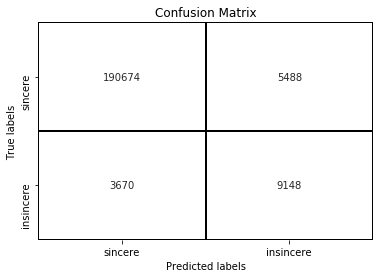

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = confusion_matrix(y_val, np.array(pred_val > threshold).astype(int))
ax = plt.subplot()
hm = sns.heatmap(cm, annot=True, ax = ax, fmt='g', 
                 cmap=ListedColormap(['white']), linecolor='black', 
                 linewidth=1, cbar=False,
                 xticklabels = 1, yticklabels = 1 )


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['sincere', 'insincere'])
ax.yaxis.set_ticklabels(['sincere', 'insincere'])



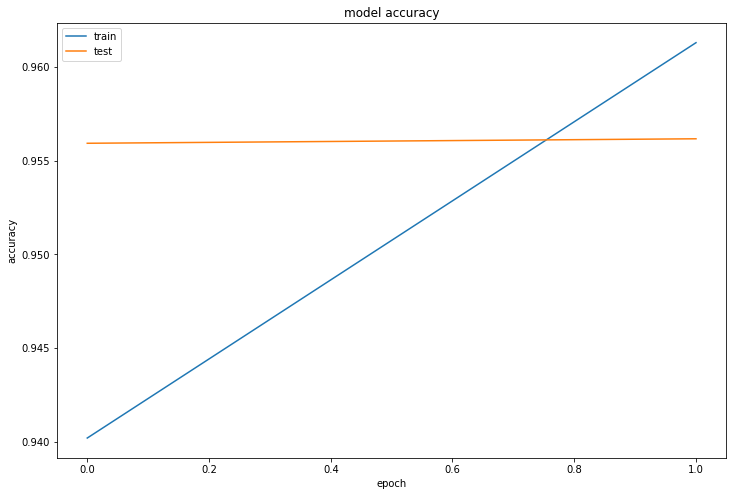

In [69]:
plt.figure(figsize=(12,8))
plt.title('model accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

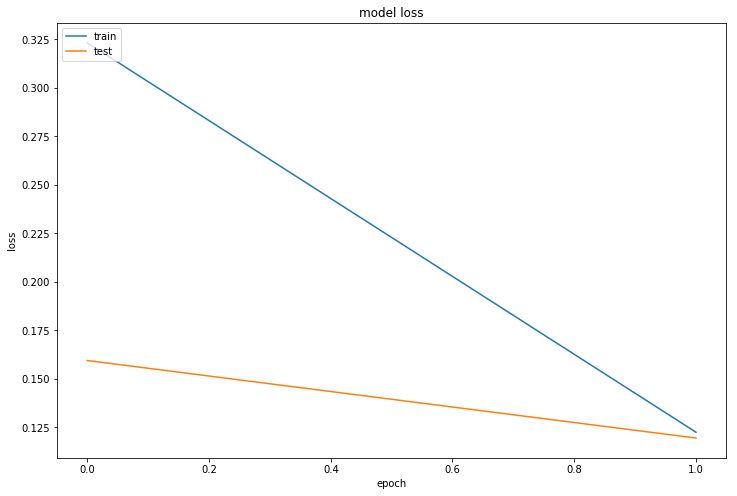

In [70]:
plt.figure(figsize=(12,8))
plt.title('model loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

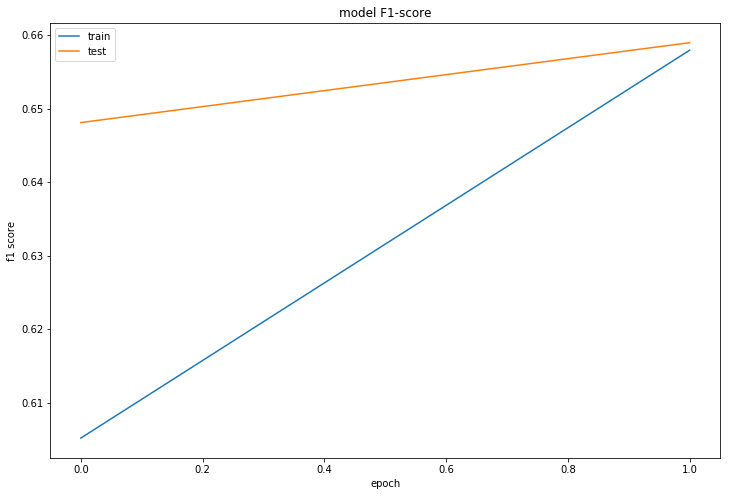

In [71]:
plt.figure(figsize=(12,8))
plt.title('model F1-score')
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# serialize weights

In [72]:
model.save_weights(MODEL_VERSION + '.weights.h5')
print("Saved model weights to disk")

Saved model weights to disk


# Predict test labels

In [73]:
%%time

pred_test = model.predict([X_test], batch_size=1024, verbose=1)

56370/56370 [==============================] - 1s 12us/step
CPU times: user 648 ms, sys: 140 ms, total: 788 ms
Wall time: 653 ms


# Prepare submission

In [74]:
submission_df = pd.DataFrame({"qid":test_df["qid"].values})
submission_df['prediction'] = (pred_test > threshold).astype(int)
submission_df.to_csv("submission.csv", index=False)

In [75]:
type(hist)

keras.callbacks.History

In [76]:
import pickle


pickle_out = open(MODEL_VERSION + '.hist.pkl',"wb")
pickle.dump(hist, pickle_out)
pickle_out.close()